# Import Libraries

In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [81]:
train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./mnist", train=False, download=True, transform=transform)

In [82]:
batch_size = 100
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Visualization

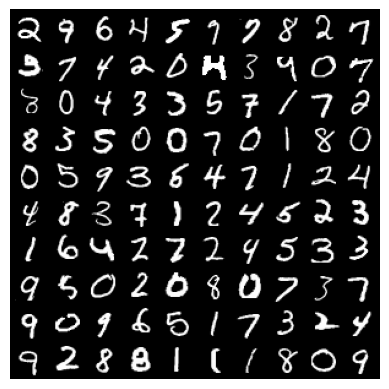

In [83]:
data_iter = iter(train_dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap="gray")
    plt.axis("off")
    plt.show()

imshow(make_grid(images, nrow=10))

# Restricted Boltzmann Machine (RBM)

In [90]:
class RestrictedBoltzmannMachine(nn.Module):
    def __init__(self, n_input, n_hidden, k, device):
        super(RestrictedBoltzmannMachine, self).__init__()
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.k = k
        self.W = nn.Parameter(torch.randn(n_hidden, n_input) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(n_input))
        self.b2 = nn.Parameter(torch.zeros(n_hidden))
        self.to(device)
    
    def sample_from_p(self, p):
        return torch.bernoulli(p).to(device)

    def v_to_h(self, v):
        activations = torch.sigmoid(F.linear(v, self.W, self.b2))
        return activations, self.sample_from_p(activations)

    def h_to_v(self, h):
        p_v = torch.sigmoid(F.linear(h, self.W.t(), self.b1))
        return p_v, self.sample_from_p(p_v)

    def forward(self, v):
        v = v.to(device)
        _, h = self.v_to_h(v)
        h_ = h
        
        for _ in range(self.k):
            _, v_ = self.h_to_v(h_)
            _, h_ = self.v_to_h(v_)

        return v, v_
    
    def free_energy(self, v):
        vbias_term = torch.matmul(v, self.b1).sum()
        wx_b = torch.matmul(v, self.W.t()) + self.b2
        hidden_term = torch.sum(F.softplus(wx_b), dim=1)
        return -(vbias_term + hidden_term).mean()

In [91]:
rbm = RestrictedBoltzmannMachine(n_input=28 * 28, n_hidden=500, k=5, device=device)

# Train

In [92]:
optimizer = optim.SGD(rbm.parameters(), lr=0.1)

In [93]:
losses = []

In [94]:
epochs = 50

In [95]:
for epoch in range(epochs):
    total_loss = 0.0

    for data, _ in train_dataloader:
        sample_data = data.view(-1, 784).bernoulli().to(device)

        v, v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    losses.append(avg_loss)
    print(f"[Epoch {epoch + 1}/{epochs}] - [Loss: {avg_loss:.4f}]")

[Epoch 1/50] - [Loss: 13295.8983]
[Epoch 2/50] - [Loss: 7708.0200]
[Epoch 3/50] - [Loss: 5800.8690]
[Epoch 4/50] - [Loss: 4606.2117]
[Epoch 5/50] - [Loss: 3865.2475]
[Epoch 6/50] - [Loss: 3275.0774]
[Epoch 7/50] - [Loss: 3036.1543]
[Epoch 8/50] - [Loss: 2681.7606]
[Epoch 9/50] - [Loss: 2545.3431]
[Epoch 10/50] - [Loss: 2418.5644]
[Epoch 11/50] - [Loss: 2291.2195]
[Epoch 12/50] - [Loss: 2211.6573]
[Epoch 13/50] - [Loss: 2114.9814]
[Epoch 14/50] - [Loss: 2035.0191]
[Epoch 15/50] - [Loss: 2022.4215]
[Epoch 16/50] - [Loss: 1894.8447]
[Epoch 17/50] - [Loss: 1909.5713]
[Epoch 18/50] - [Loss: 1839.3462]
[Epoch 19/50] - [Loss: 1800.6738]
[Epoch 20/50] - [Loss: 1844.3216]
[Epoch 21/50] - [Loss: 1765.5057]
[Epoch 22/50] - [Loss: 1767.0250]
[Epoch 23/50] - [Loss: 1668.1435]
[Epoch 24/50] - [Loss: 1718.3208]
[Epoch 25/50] - [Loss: 1612.8247]
[Epoch 26/50] - [Loss: 1654.5973]
[Epoch 27/50] - [Loss: 1631.4647]
[Epoch 28/50] - [Loss: 1626.0720]
[Epoch 29/50] - [Loss: 1601.9388]
[Epoch 30/50] - [Loss:

# Results

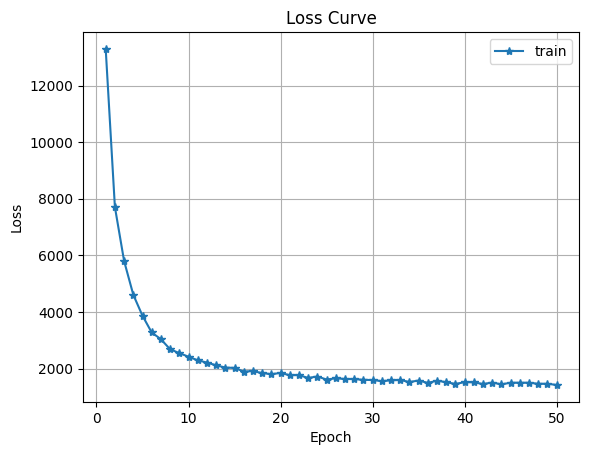

In [102]:
plt.figure()
plt.plot(range(1, epochs + 1), losses, marker="*")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend(["train"])
plt.grid(True)
plt.show()

In [121]:
def reconstruct_images(test_dataloader, count=5):
    for _ in range(count):
        random_idx = np.random.randint(len(test_dataloader.dataset))
        
        original_image = test_dataloader.dataset[random_idx][0].numpy().reshape(28, 28)
        sample_data = torch.bernoulli(test_dataloader.dataset[random_idx][0]).numpy().reshape(28, 28)
        v, v_ = rbm(torch.tensor(sample_data).view(1, -1))
        reconstructed_image = v_.cpu().detach().numpy().reshape(28, 28)
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
        
        axes[0].imshow(original_image, cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        
        axes[1].imshow(reconstructed_image, cmap="gray")
        axes[1].set_title("Reconstructed Image")
        axes[1].axis("off")

        plt.show()

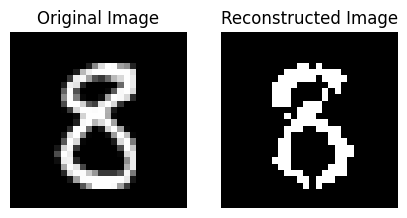

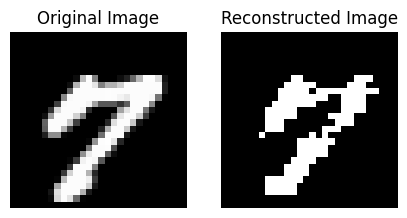

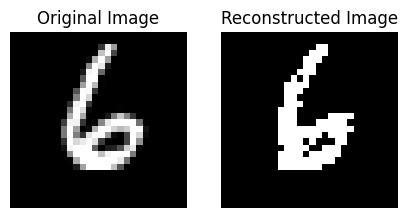

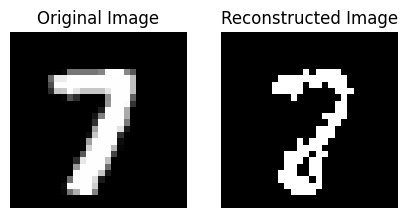

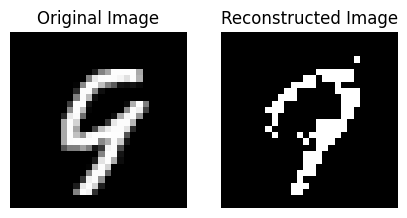

In [122]:
reconstruct_images(test_dataloader, count=5)